In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
import pickle

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [5]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

/home/jupyter/BayesFlow/bayesflow/trainers.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
benchmarks.available_benchmarks

['gaussian_linear',
 'gaussian_linear_uniform',
 'slcp',
 'slcp_distractors',
 'bernoulli_glm',
 'bernoulli_glm_raw',
 'gaussian_mixture',
 'two_moons',
 'sir',
 'lotka_volterra']

# Two Moons

In [7]:
benchmark_name = 'two_moons'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the two_moons model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [8]:
# Loss for posterior
mixture = tfp.distributions.Mixture(
    cat=tfd.Categorical(probs=[0.5, 0.5]),
    components=[
        tfd.MultivariateNormalDiag(loc=[-2, -2], scale_diag=[1., 1.]),
        tfd.MultivariateNormalDiag(loc=[2, 2], scale_diag=[1., 1.]),
    ]
)

2023-01-23 10:43:57.192926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 10:43:57.204622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 10:43:57.205309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 10:43:57.206745: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
SETTINGS_POST = {
    't_args': {
        'dense_args': dict(units=256, activation='tanh'), 'n_dense': 2, 'dropout': True, 'dropout_prob': 0.05
    },
    's_args': {
        'dense_args': dict(units=256, activation='tanh'), 'n_dense': 2, 'dropout': True, 'dropout_prob': 0.05
    }
}

SETTINGS_LIK = {
    't_args': {
        'dense_args': dict(units=64, activation='tanh'), 'n_dense': 2, 'dropout': True, 'dropout_prob': 0.05
    },
    's_args': {
        'dense_args': dict(units=64, activation='tanh'), 'n_dense': 2, 'dropout': True, 'dropout_prob': 0.05
    }
}

In [10]:
amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(
        InvertibleNetwork(num_params=2, num_coupling_layers=6, coupling_net_settings=SETTINGS_POST), latent_dist=mixture),
    AmortizedLikelihood(
        InvertibleNetwork(num_params=2, num_coupling_layers=6, coupling_net_settings=SETTINGS_LIK))
)

In [11]:
trainer = Trainer(
    amortizer=amortizer,
    default_lr=1e-3,
    generative_model=benchmark.generative_model,
    configurator=benchmark.configurator,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False   
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training

In [13]:
# EPOCHS = 128
# SIMULATION_BUDGET = 10000
# N_VAL = 300
# BATCH_SIZE = 128

# train_data = trainer.generative_model(SIMULATION_BUDGET)

# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Trajectories

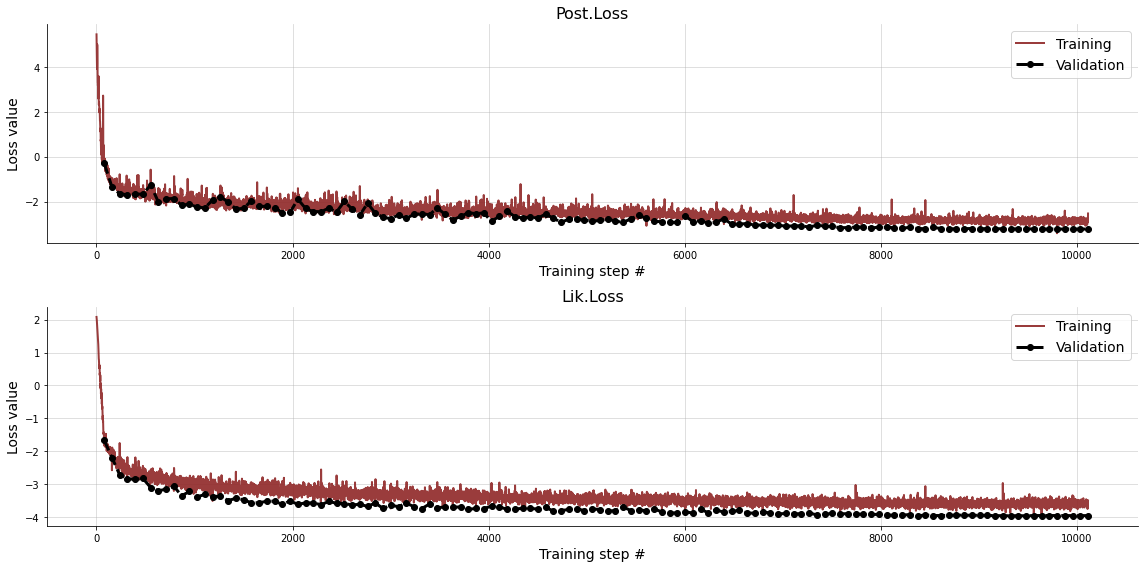

In [14]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

## Test Canonical Posterior

In [15]:
samples = amortizer.sample_parameters({'direct_conditions': np.zeros((1, 2), dtype=np.float32)}, 1000)

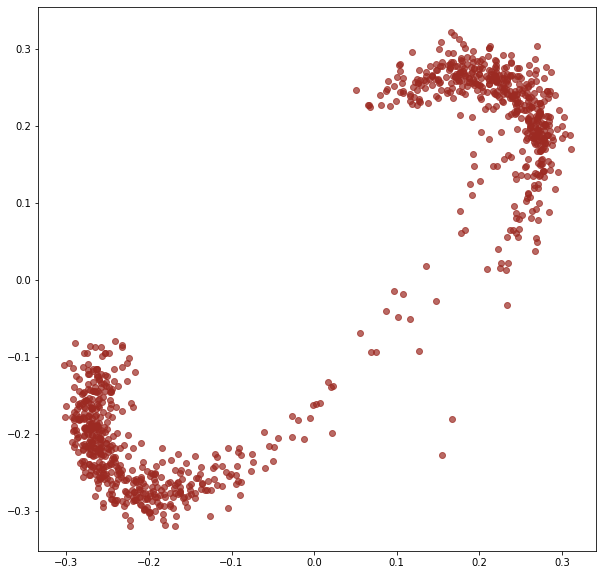

In [17]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(samples[:, 0], samples[:, 1], color='#9c2a22', alpha=0.7)

## Test (Held-Out) Data

In [18]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

## Latent Inspection

In [19]:
out_p, out_l = amortizer(test_dict)
z_p = out_p[0]
z_l = out_l[0]

### Posterior

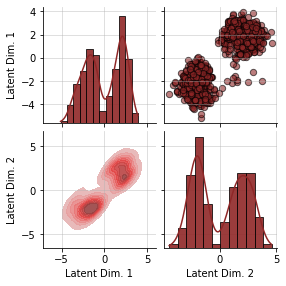

In [20]:
f = plot_latent_space_2d(z_p, height=2)

### Likelihood

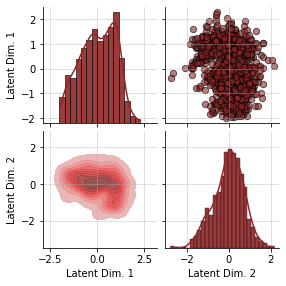

In [36]:
f = plot_latent_space_2d(z_l, height=2)

In [21]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'direct_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

## Calibration

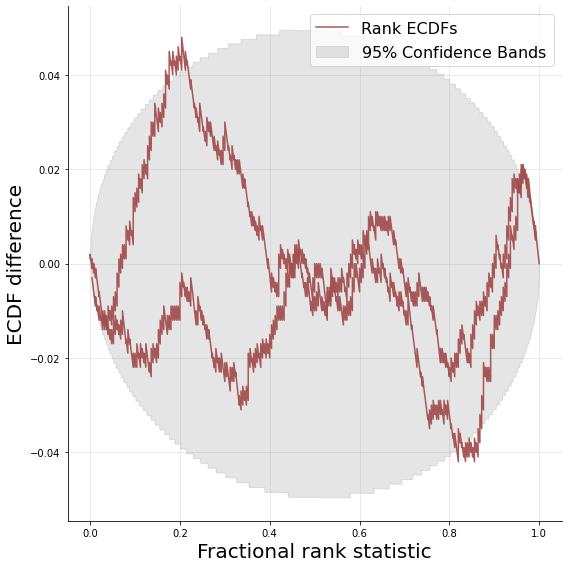

In [22]:
# Posterior given simulator outputs
f = plot_sbc_ecdf(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True,
                  difference=True, fig_size=(8, 8), label_fontsize=20, legend_fontsize=16)

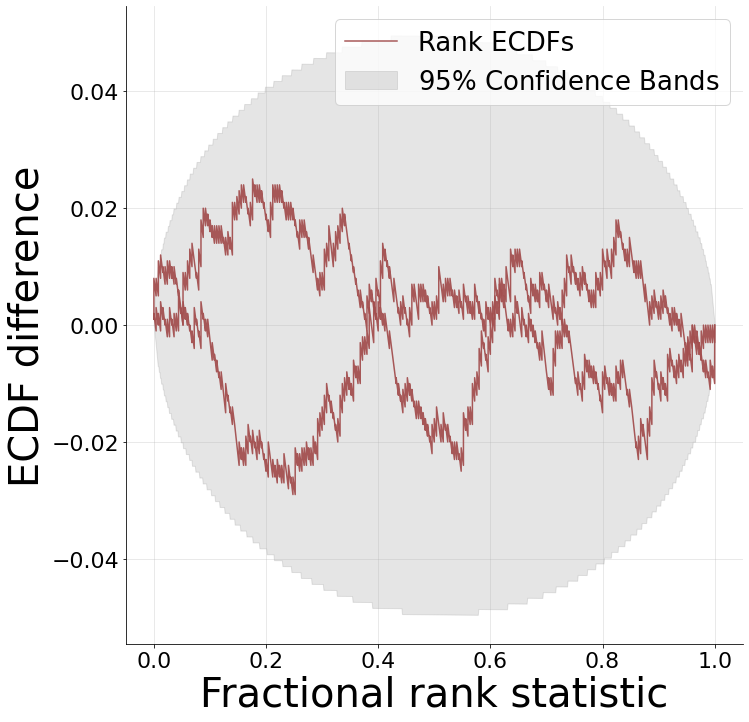

In [23]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True,
                  difference=True, fig_size=(10, 10), label_fontsize=40, legend_fontsize=26)
_ = plt.xticks(fontsize=22)
_ = plt.yticks(fontsize=22)
f.savefig(f'figures/calibration/{benchmark_name}_diff.pdf', dpi=300, bbox_inches='tight')

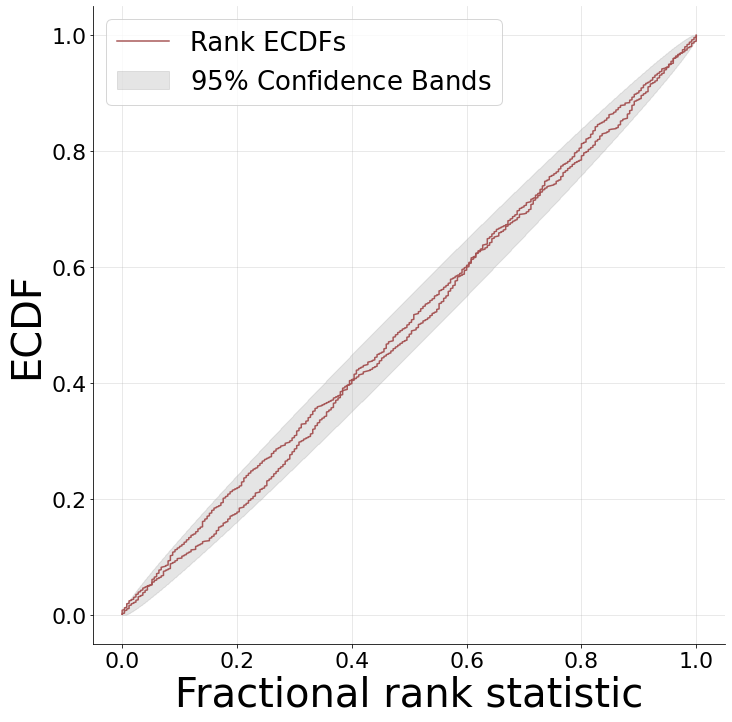

In [24]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True, fig_size=(10, 10), label_fontsize=40, legend_fontsize=26)
_ = plt.xticks(fontsize=22)
_ = plt.yticks(fontsize=22)
f.savefig(f'figures/calibration/{benchmark_name}.pdf', dpi=300, bbox_inches='tight')